In [1]:
# from utils import EMA, ROC, MOM, RSI, STOK, MA

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import sklearn

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
from sklearn.metrics import roc_auc_score

In [9]:
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

# Backtest results
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
def backtest(X_validation, Y_validation, predictions):
    backtestdata = pd.DataFrame(index=X_validation.index)
    backtestdata['signal_pred'] = predictions
    backtestdata['signal_actual'] = Y_validation
    backtestdata['Market Returns'] = X_validation['Close'].pct_change()
    backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
    backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
    backtestdata=backtestdata.reset_index()
    backtestdata.head()
    backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
    backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
    
    return backtestdata

<AxesSubplot:xlabel='signal', ylabel='count'>

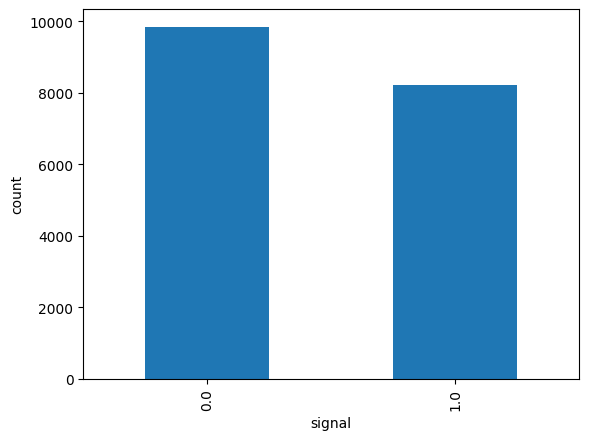

In [10]:
pd.read_csv('data/train.csv').signal.value_counts().plot.bar(xlabel = 'signal', ylabel = 'count')

In [11]:
data_test = pd.read_csv('data/test.csv')

In [12]:
y_pred_timestamp = data_test['Timestamp']

In [13]:
data_test.columns = data_test.columns.str.lower()

In [14]:
data = pd.read_csv('data/train.csv')

In [15]:
data = data.sort_values(by='timestamp').reset_index()

In [16]:
data = (data.assign(EMA10 = lambda df: EMA(df, 10))
        .assign(EMA30 = lambda df: EMA(df, 30))
        .assign(EMA200 = lambda df: EMA(df, 200))
        .assign(ROC10 = lambda df: ROC((df['close']), 10))
        .assign(MOM10 = lambda df: MOM((df['close']), 10))
        .assign(MOM30 = lambda df: MOM((df['close']), 30))
        .assign(RSI10 = lambda df: RSI((df['close']), 10))
        .assign(RSI30 = lambda df: RSI((df['close']), 30))
        .assign(RSI200 = lambda df: RSI((df['close']), 200))
        .assign(MA10 = lambda df: MA(df, 10))
        .assign(MA30 = lambda df: MA(df, 30))
        .assign(MA200 = lambda df: MA(df, 200))
                )

In [17]:
data.columns = data.columns.str.lower()

In [18]:
test_columns = ["Timestamp","Close","EMA10","EMA30","EMA200","ROC10","ROC30","MOM10","MOM30","RSI10","RSI30","RSI200","%K10","%D10","%K30","%D30","%K200","%D200","MA10","MA30","MA200"]

In [19]:
test_columns_lower = list(map(lambda x: x.lower(), test_columns))

In [20]:
test_columns_lower

['timestamp',
 'close',
 'ema10',
 'ema30',
 'ema200',
 'roc10',
 'roc30',
 'mom10',
 'mom30',
 'rsi10',
 'rsi30',
 'rsi200',
 '%k10',
 '%d10',
 '%k30',
 '%d30',
 '%k200',
 '%d200',
 'ma10',
 'ma30',
 'ma200']

In [21]:
data = data[200:]

In [22]:
X = data.loc[:,data.columns.isin(test_columns_lower)]

In [23]:
y = data.signal

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
scaler =  StandardScaler()

In [26]:
X_train = scaler.fit_transform(X_train)

In [27]:
X_test = scaler.transform(X_test)

In [28]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=20, n_jobs=-1)

In [29]:
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=20, n_jobs=-1)

In [30]:
roc_auc_score(y_test, rf.predict(X_test))

0.9115197622729868

In [31]:
X = X.drop('timestamp', axis=1)

In [32]:
X

,close,ema200,ma200,rsi200,%k30,ema10,ema30,ema200,roc10,mom10,mom30,rsi10,rsi30,rsi200,ma10,ma30,ma200
200,5.04,4.897158,4.86460,50.814380,100.000000,5.012654,4.975558,4.889170,0.598802,0.03,0.20,61.343204,57.417173,53.642384,5.009,4.974667,4.86460
201,4.90,4.897186,4.86625,49.834454,26.315789,4.992172,4.970683,4.889294,-2.390438,-0.11,0.03,35.548584,47.786216,52.421217,4.998,4.975667,4.86625
202,4.99,4.898109,4.86760,50.451796,73.684211,4.991777,4.971930,4.890448,-0.597610,-0.03,0.12,50.435517,53.026104,53.110870,4.995,4.979667,4.86760
203,4.98,4.898924,4.86875,50.382560,68.421053,4.989636,4.972450,4.891472,-1.190476,-0.04,0.05,49.037176,52.421423,53.025041,4.991,4.981333,4.86875
204,5.00,4.899930,4.86985,50.519050,78.947368,4.991520,4.974228,4.892711,1.419878,-0.04,0.07,51.994861,53.518087,53.177136,4.987,4.983667,4.86985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18065,10.64,10.624384,10.59565,49.791687,82.608696,10.609500,10.627613,10.630061,-0.187617,-0.03,-0.03,52.656789,50.659366,49.789480,10.620,10.626000,10.60240
18066,10.63,10.624440,10.59520,49.725912,78.260870,10.613227,10.627767,10.630060,-0.281426,-0.03,-0.04,51.224050,49.968532,49.711786,10.617,10.624667,10.60210
18067,10.63,10.624440,10.59520,49.725912,78.260870,10.616277,10.627911,10.630060,-0.374883,-0.03,-0.04,51.224050,49.968532,49.711786,10.614,10.623333,10.60180
18068,10.66,10.624793,10.59490,49.925356,91.304348,10.624226,10.629981,10.630358,-0.093721,-0.01,0.02,55.689410,52.067065,49.948455,10.613,10.624000,10.60170


In [33]:
data_test = data_test.loc[:,data_test.columns.isin(data.columns)][X.columns.tolist()]

In [34]:
data_test

,close,ema200,ma200,rsi200,%k30,ema10,ema30,ema200,roc10,mom10,mom30,rsi10,rsi30,rsi200,ma10,ma30,ma200
0,10.68,10.625343,10.59470,50.058105,100.000000,10.639059,10.636231,10.625343,0.093721,0.02,0.01,54.947707,52.577501,50.058105,10.641,10.646667,10.59470
1,10.68,10.625887,10.59585,50.058105,100.000000,10.646502,10.639055,10.625887,0.093721,0.01,0.01,54.947707,52.577501,50.058105,10.642,10.647000,10.59585
2,10.64,10.626027,10.59650,49.791450,82.608696,10.645320,10.639116,10.626027,-0.187617,-0.03,-0.04,49.730027,50.688799,49.791450,10.639,10.645667,10.59650
3,10.60,10.625768,10.59705,49.526302,65.217391,10.637080,10.636592,10.625768,-0.656045,-0.06,-0.08,44.983869,48.872645,49.526302,10.633,10.643000,10.59705
4,10.50,10.624517,10.59710,48.872398,21.739130,10.612157,10.627780,10.624517,-1.685393,-0.17,-0.18,35.557367,44.728033,48.872398,10.616,10.637000,10.59710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4900,13.34,13.370544,13.37065,49.995688,0.000000,13.381654,13.397634,13.370544,-0.670141,-0.09,-0.05,17.747752,37.647693,49.995688,13.394,13.406000,13.37065
4901,13.33,13.370141,13.37030,49.868857,0.000000,13.372263,13.393270,13.370141,-0.744602,-0.10,-0.06,15.850286,36.089430,49.868857,13.384,13.404000,13.37030
4902,13.42,13.370637,13.37040,50.993373,90.000000,13.380942,13.394995,13.370637,-0.074460,-0.01,0.03,59.330877,53.867217,50.993373,13.383,13.405000,13.37040
4903,13.34,13.370332,13.37005,49.991577,10.000000,13.373498,13.391447,13.370332,-0.670141,-0.09,-0.05,39.283488,42.895241,49.991577,13.374,13.403333,13.37005


In [35]:
f_scaler =  StandardScaler()

In [36]:
X_train_f = f_scaler.fit_transform(X)

In [37]:
y_train_f = y

In [38]:
X_test_f = f_scaler.transform(data_test)

In [39]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=20, n_jobs=-1)

In [40]:
X_train_f, y_train_f

(array([[-1.83988404, -1.88275812, -1.88988948, ..., -1.85177366,
         -1.86341957, -1.88923779],
        [-1.89535653, -1.88274704, -1.88923812, ..., -1.85613261,
         -1.86302345, -1.8885866 ],
        [-1.85969564, -1.88238156, -1.8887052 , ..., -1.85732141,
         -1.86143898, -1.8880538 ],
        ...,
        [ 0.37505302,  0.38507254,  0.37231199, ...,  0.36930711,
          0.37411492,  0.37501474],
        [ 0.38693998,  0.38521232,  0.37219357, ...,  0.36891085,
          0.374379  ,  0.37497527],
        [ 0.38693998,  0.38521232,  0.37219357, ...,  0.36851458,
          0.37464308,  0.3749358 ]]),
 200      1.0
 201      1.0
 202      1.0
 203      1.0
 204      1.0
         ... 
 18065    0.0
 18066    0.0
 18067    0.0
 18068    0.0
 18069    0.0
 Name: signal, Length: 17870, dtype: float64)

In [41]:
X_train_f_split, _, y_train_f_split, _ = train_test_split(X_train_f, y_train_f, test_size=0.33, random_state=42)

In [42]:
rf.fit(X_train_f, y_train_f)

RandomForestClassifier(min_samples_split=20, n_jobs=-1)

In [43]:
y_pred_f = rf.predict(X_test_f)

In [44]:
y_pred_f

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
pd.DataFrame([y_pred_timestamp, y_pred_f], index= ['Timestamp','signal']).T.signal.value_counts()

0.0    2987
1.0    1918
Name: signal, dtype: int64

In [46]:
pd.DataFrame([y_pred_timestamp, y_pred_f], index= ['Timestamp','signal']).T.astype({'Timestamp':int}).to_csv('data/base_sub.csv', index=False)

In [50]:
pd.read_csv('base_sub.csv').signal.value_counts()

0.0    2960
1.0    1945
Name: signal, dtype: int64

In [57]:
(pd.read_csv('base_sub.csv') == pd.read_csv('data/base_sub.csv')).signal.value_counts()

True     4574
False     331
Name: signal, dtype: int64

In [59]:
from sklearn.linear_model import LogisticRegression

In [63]:
lr = LogisticRegression(C=0.1)

In [64]:
lr.fit(X_train_f, y_train_f)

LogisticRegression(C=0.1)

In [70]:
y_pred_f = lr.predict(X_test_f)

In [71]:
pd.DataFrame([y_pred_timestamp, y_pred_f], index= ['Timestamp','signal']).T.signal.value_counts()

1.0    2785
0.0    2120
Name: signal, dtype: int64

In [72]:
pd.DataFrame([y_pred_timestamp, y_pred_f], index= ['Timestamp','signal']).T.astype({'Timestamp':int}).to_csv('data/base_sub_lr.csv', index=False)

In [73]:
(pd.read_csv('data/base_sub_lr.csv') == pd.read_csv('data/base_sub.csv')).signal.value_counts()

False    2471
True     2434
Name: signal, dtype: int64